In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13086536104303855418
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11338085172
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 7393733347830966612
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:88:00.0, compute capability: 3.7"
]


In [3]:

from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table

import os
import platform

mpl.rc('font', size=14)

In [4]:
import pickle 

with open('host_flux.data', 'rb') as filehandle:
    host_flux = pickle.load(filehandle)

In [5]:
with open('snia_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snia_flux = pickle.load(filehandle)

In [6]:
with open('snib_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snib_flux = pickle.load(filehandle)

In [7]:
with open('snibc_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snibc_flux = pickle.load(filehandle)

In [8]:
with open('snic_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snic_flux = pickle.load(filehandle)

In [9]:
with open('sniilp_flux .data', 'rb') as filehandle:
    # read the data as binary data stream
    sniilp_flux = pickle.load(filehandle)

In [10]:
with open('sniin_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    sniin_flux = pickle.load(filehandle)

In [11]:
with open('sniip_flux .data', 'rb') as filehandle:
    # read the data as binary data stream
    sniip_flux = pickle.load(filehandle)

In [12]:
nhost, nbins  = host_flux.shape
nsnia, nbins  = snia_flux.shape
nsnib, nbins  = snib_flux.shape
nsnibc, nbins = snibc_flux.shape
nsnic, nbins  = snic_flux.shape
nsniin, nbins = sniin_flux.shape
nsniilp, nbins = sniilp_flux.shape
nsniip, nbins = sniip_flux.shape
nhost, nsnia, nsnib, nsnibc, nsnic, nsniin, nsniilp, nsniip, nbins

(9969, 9964, 9958, 9971, 8269, 9949, 9948, 9962, 150)

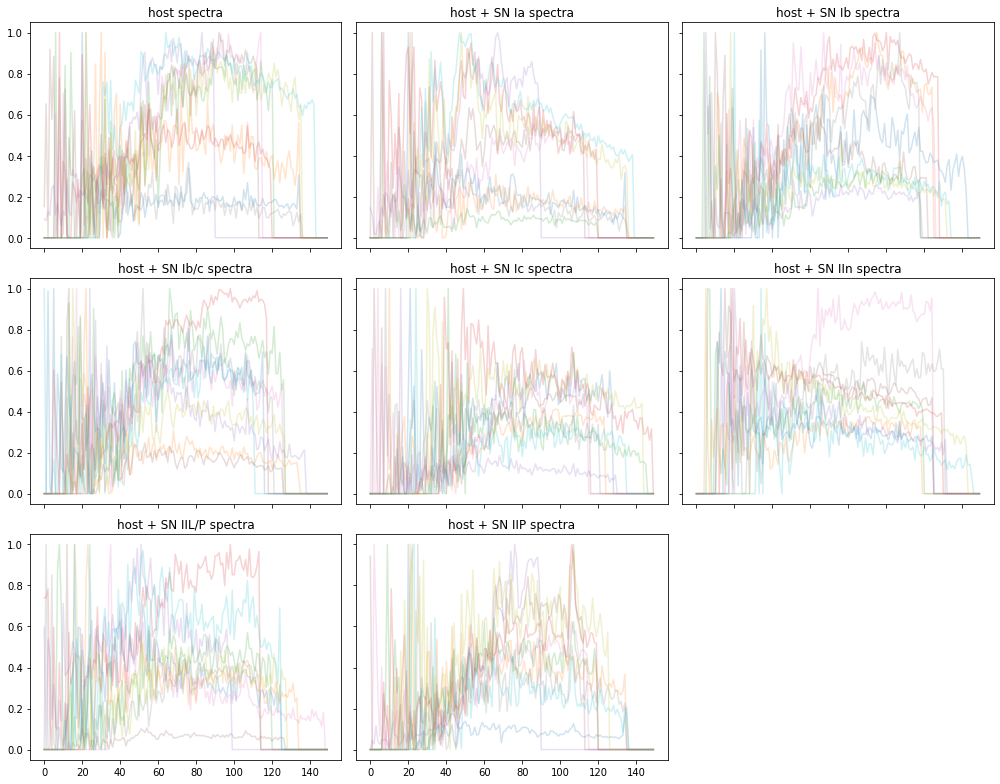

In [13]:
# PLOT
fig, axes = plt.subplots(3,3, figsize=(14,11), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(0,50,5):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
    ax = axes[2]
    ax.plot(snib_flux[i], alpha=0.2)
    
    ax = axes[3]
    ax.plot(snibc_flux[i], alpha=0.2)
    
    ax = axes[4]
    ax.plot(snic_flux[i], alpha=0.2)
    
    ax = axes[5]
    ax.plot(sniin_flux[i], alpha=0.2)

    ax = axes[6]
    ax.plot(sniilp_flux[i], alpha=0.2)
    
    ax = axes[7]
    ax.plot(sniip_flux[i], alpha=0.2)
    
axes[0].set_title('host spectra')
axes[1].set_title('host + SN Ia spectra')
axes[2].set_title('host + SN Ib spectra')
axes[3].set_title('host + SN Ib/c spectra')
axes[4].set_title('host + SN Ic spectra')
axes[5].set_title('host + SN IIn spectra')
axes[6].set_title('host + SN IIL/P spectra')
axes[7].set_title('host + SN IIP spectra')

axes[8].axis('off')

fig.tight_layout()


x = np.concatenate([host_flux, 
                    snia_flux,
                    snib_flux,
                    snibc_flux,
                    snic_flux,
                    sniin_flux,
                    sniilp_flux,
                    sniip_flux
                   ]).reshape(-1, nbins, 1)

labels = ['Host',
          'SN Ia',
          'SN Ib',
          'SN Ib/c',
          'SN Ic',
          'SN IIn',
          'SN IIL/P',
          'SN IIP']
ntypes = len(labels)

# Convert y-label array to appropriate categorical array
from tensorflow.keras.utils import to_categorical

y = to_categorical(
        np.concatenate([np.full(nhost, 0), 
                        np.full(nsnia, 1),
                        np.full(nsnib, 2),
                        np.full(nsnibc, 3),
                        np.full(nsnic, 4),
                        np.full(nsniin, 5),
                        np.full(nsniilp, 6),
                        np.full(nsniip, 7)
                       ]))

In [14]:
import tensorflow as tf
from tensorflow.keras import utils, regularizers, callbacks, backend
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout, Add, LSTM, Embedding
from tensorflow.keras.initializers import glorot_normal, glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM

In [15]:
# Split data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)

In [59]:
"""Function takes in the optimizer and kernel sizes
returns acc vs epoch plot, the roc, pr curve, and cm"""

def optimizer(optimizer,kernel_size):
    n = kernel_size
    def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
        """Define the CNN structure.

        Parameters
        ----------
        input_shape : int
        Shape of the input spectra.
        ncat : int
        Number of categories.
        learning_rate : float
        Learning rate.
        reg : float
        Regularization factor.
        dropout : float
        Dropout rate.
        seed : int
        Seed of initializer.

        Returns
        -------
        model : tensorflow.keras.Model
        A model instance of the network.
        """

        X_input = Input(input_shape, name='Input_Spec')

        # First convolutional layer.
        with backend.name_scope('Conv_1'):
            X = Conv1D(filters=8, kernel_size=n, strides=1, padding='same',
                       kernel_regularizer=regularizers.l2(reg),
                       bias_initializer='zeros',
                       kernel_initializer=glorot_normal(seed))(X_input)
            X = BatchNormalization(axis=2)(X)
            X = Activation('relu')(X)
            X = MaxPooling1D(pool_size= 2)(X)

        # Second convolutional layer.
        with backend.name_scope('Conv_2'):
            X = Conv1D(filters=16, kernel_size=n, strides=1, padding='same',
                       kernel_regularizer=regularizers.l2(reg),
                       bias_initializer='zeros',
                       kernel_initializer=glorot_normal(seed))(X)
            X = BatchNormalization(axis=2)(X)
            X = Activation('relu')(X)
            X = MaxPooling1D(2)(X)

        # Third convolutional layer.
        with backend.name_scope('Conv_3'):
            X = Conv1D(filters=32, kernel_size=n, strides=1, padding='same',
                       kernel_regularizer=regularizers.l2(reg),
                       bias_initializer='zeros',
                       kernel_initializer=glorot_normal(seed))(X)
            X = BatchNormalization(axis=2)(X)
            X = Activation('relu')(X)
            X = MaxPooling1D(2)(X)

        # Fourth convolutional layer.
        with backend.name_scope('Conv_4'):
            X = Conv1D(filters=64, kernel_size=n, strides=1, padding='same',
                       kernel_regularizer=regularizers.l2(reg),
                       bias_initializer='zeros',
                       kernel_initializer=glorot_normal(seed))(X)
            X = BatchNormalization(axis=2)(X)
            X = Activation('relu')(X)
            X = MaxPooling1D(2)(X)

        # Flatten to fully connected dense layer.
        with backend.name_scope('Dense_Layer'):
            X = Flatten()(X)
            X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                      activation='relu')(X)
            X = Dropout(rate=dropout, seed=seed)(X)

        #     with backend.name_scope('Dense_Layer'):
        #         X = Flatten()(X)
        #         X = Dense(512, kernel_regularizer=regularizers.l2(reg),
        #                   activation='relu')(X)
        #         X = Dropout(rate=dropout, seed=seed)(X)

        # Output layer with sigmoid activation.
        with backend.name_scope('Output_Layer'):
            X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
                  activation='softmax',name='Output_Classes')(X)

        model = Model(inputs=X_input, outputs=X, name='SNnet')

        # Set up optimizer, loss function, and optimization metrics.
        model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model
    
    # Training and testing the model
    model = network((nbins, 1),ncat=y.shape[1])
    hist = model.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)
    
    title = optimizer+"kernel ={0}".format(n)
    # Plotting epoch vs accuracy 
    fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=True)
    fig.suptitle(title, fontsize=16)
    nepoch = len(hist.history['loss'])
    epochs = np.arange(1, nepoch+1)

    ax = axes[0]
    ax.plot(epochs, hist.history['acc'], label='acc')
    ax.plot(epochs, hist.history['val_acc'], label='val_acc')
    ax.set(xlabel='training epoch',
           ylabel='accuracy',
           xlim=(0, nepoch),
           ylim=(0.5,1.05))
    ax.set_title('Maximum val_acc = {0:2.3f}'.format(max(hist.history['val_acc'])))
    ax.legend(fontsize=12, loc='best')
    ax.grid(ls=':')

    ax = axes[1]
    ax.plot(epochs, hist.history['loss'], label='loss')
    ax.plot(epochs, hist.history['val_loss'], label='val_loss')
    ax.set(xlabel='training epoch',
           ylabel='loss',
           xlim=(0, nepoch),
           ylim=(0.,2.0))
    ax.set_title('Minimum val_acc = {0:2.3f}'.format(min(hist.history['val_loss'])))
    ax.legend(fontsize=12, loc='best')
    ax.grid(ls=':')
    
    # Print ROC and PR Curve
    y_pred = model.predict(x_test)

    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

    fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

    all_fpr = None
    all_tpr = None

    fpr = dict()
    tpr = dict()
    pre = dict()
    rec = dict()
    for i in range(ntypes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
        roc_auc = auc(fpr[i], tpr[i])

        ax = axes[0]
        ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
        ax.grid(ls=':')

        pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        ax = axes[1]
        ax.plot(rec[i], pre[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(ntypes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr / ntypes
    fpr['macro'] = np.insert(fpr['macro'], 0, 0)
    tpr['macro'] = np.insert(tpr['macro'], 0, 0)
    roc_auc_macro = auc(fpr['macro'], tpr['macro'])

    ax = axes[0]
    ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
            label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
    ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
           ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
           title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
           aspect='equal')
    ax.legend(fontsize=10, loc='lower right')

    ax = axes[1]
    pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
    ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

    f_scores = np.linspace(0.1, 0.9, num=5)
    for f_score in f_scores:
        x_ = np.linspace(0.01, 1)
        y_ = f_score * x_ / (2 * x_ - f_score)
        l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
        ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                    fontsize=12, alpha=0.8)
    ax.grid(ls=':')
    ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
           ylabel='precision = TP / (TP + FP)',
           title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
           aspect='equal')

    fig.tight_layout()
    
    
    # CM
    from sklearn.metrics import confusion_matrix

    # In the multilabel classifier, test that the maximum of the
    # output matrix of values matches.
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(1,1, figsize=(10,9))

    im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
    cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label('correct label fraction')

    ax.set(aspect='equal',
           xlabel='predicted label',
           xticks=np.arange(cm.shape[1]),
           xticklabels=labels,
           ylabel='true label',
           yticks=np.arange(cm.shape[1]),
           yticklabels=labels)

    thresh = 0.5*cm.max()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                    ha='center', va='center',
                    color='black' if cm[i,j] < thresh else 'white')
    plt.ylim([7.5,-.5])
    fig.tight_layout()

In [60]:
# List to be checked
opt_list = ['adam','sgd',Adam(lr=.00021544346900318823),'adagrad','adadelta','rmsprop']
kernel = [3,5,9]

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 12s 203us/sample - loss: 1.9519 - acc: 0.5018 - val_loss: 1.4341 - val_acc: 0.6076
Epoch 2/30
58492/58492 [==============================] - 9s 158us/sample - loss: 1.3323 - acc: 0.6213 - val_loss: 1.2326 - val_acc: 0.6410
Epoch 3/30
58492/58492 [==============================] - 9s 159us/sample - loss: 1.2152 - acc: 0.6474 - val_loss: 1.1736 - val_acc: 0.6550
Epoch 4/30
58492/58492 [==============================] - 9s 158us/sample - loss: 1.1628 - acc: 0.6609 - val_loss: 1.1650 - val_acc: 0.6583
Epoch 5/30
58492/58492 [==============================] - 9s 158us/sample - loss: 1.1314 - acc: 0.6685 - val_loss: 1.1484 - val_acc: 0.6582
Epoch 6/30
58492/58492 [==============================] - 9s 158us/sample - loss: 1.1165 - acc: 0.6743 - val_loss: 1.0908 - val_acc: 0.6804
Epoch 7/30
58492/58492 [==============================] - 9s 158us/sample - loss: 1.0951 - acc: 0.6808 - val_

58492/58492 [==============================] - 8s 142us/sample - loss: 1.0528 - acc: 0.7105 - val_loss: 1.0876 - val_acc: 0.6943
Epoch 26/30
58492/58492 [==============================] - 8s 142us/sample - loss: 1.0404 - acc: 0.7111 - val_loss: 1.1083 - val_acc: 0.6841
Epoch 27/30
58492/58492 [==============================] - 8s 142us/sample - loss: 1.0307 - acc: 0.7132 - val_loss: 1.1180 - val_acc: 0.6803
Epoch 28/30
58492/58492 [==============================] - 8s 142us/sample - loss: 1.0221 - acc: 0.7145 - val_loss: 1.1555 - val_acc: 0.6652
Epoch 29/30
58492/58492 [==============================] - 8s 142us/sample - loss: 1.0136 - acc: 0.7141 - val_loss: 1.0526 - val_acc: 0.7013
Epoch 30/30
58492/58492 [==============================] - 8s 142us/sample - loss: 1.0049 - acc: 0.7160 - val_loss: 1.0630 - val_acc: 0.6943
Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 12s 199us/sample - loss: 2.9335 - acc: 0.4196 - val_loss: 

TypeError: unsupported operand type(s) for +: 'Adam' and 'str'

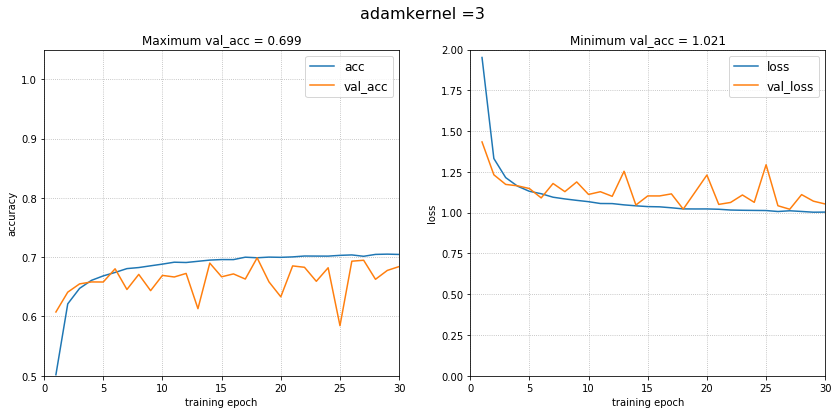

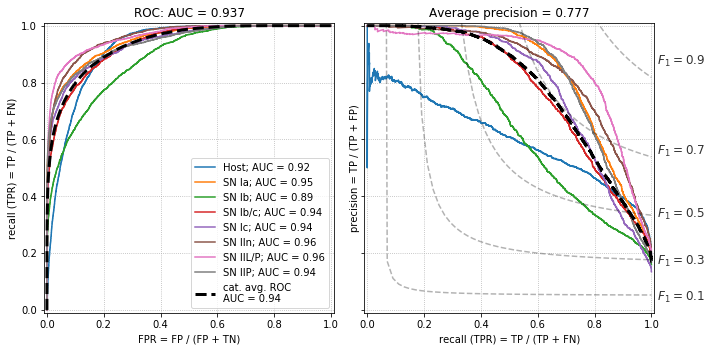

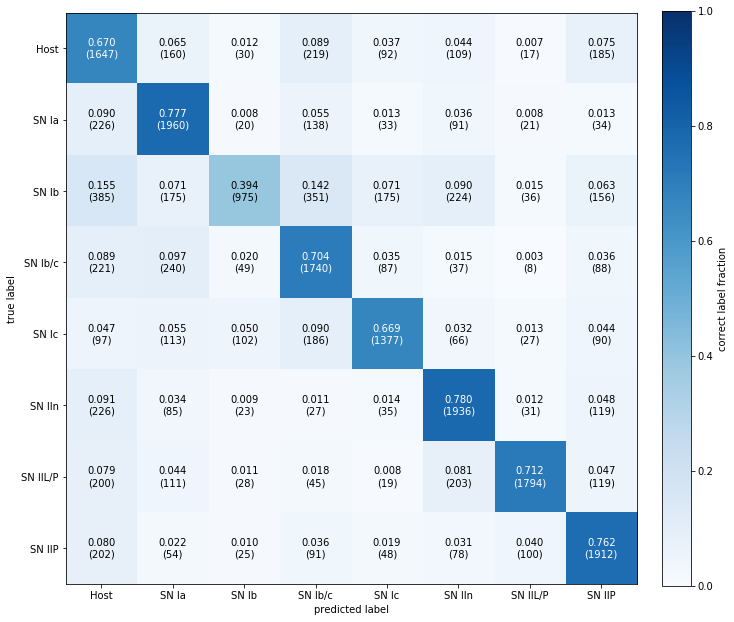

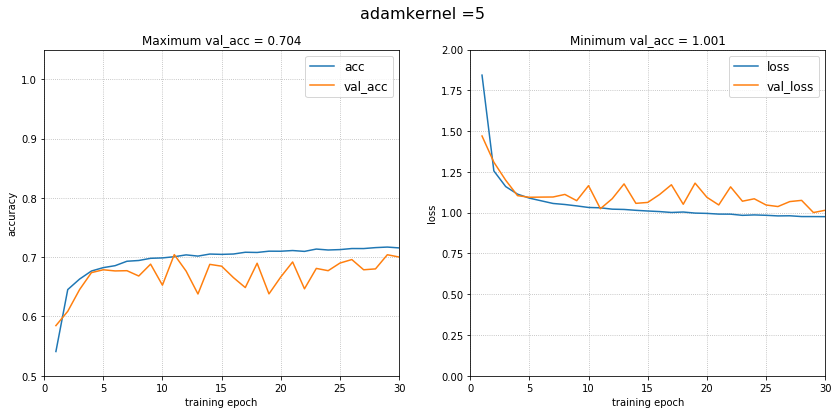

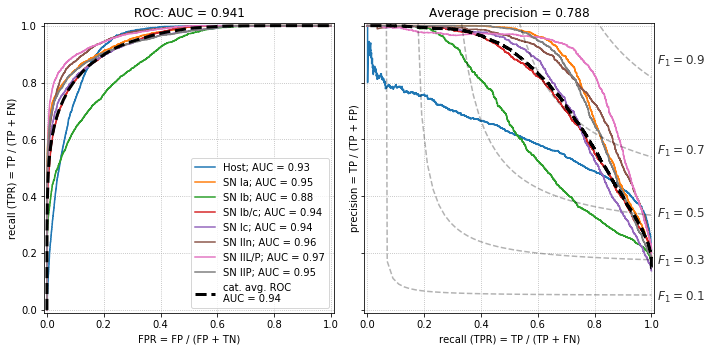

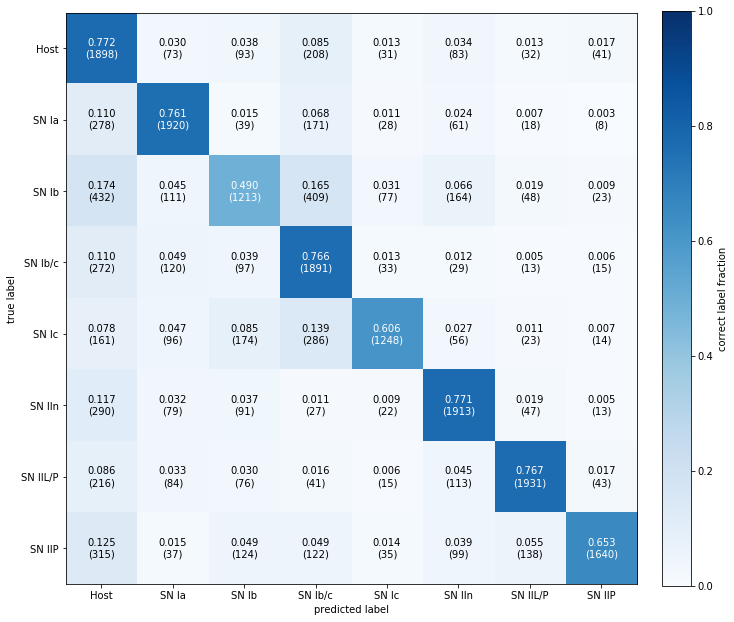

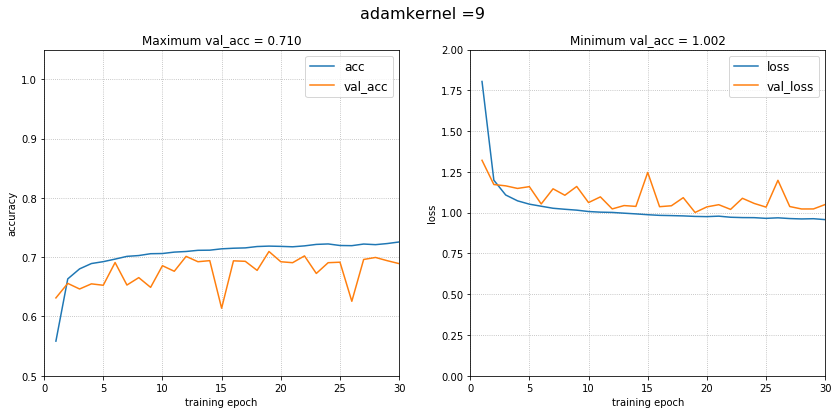

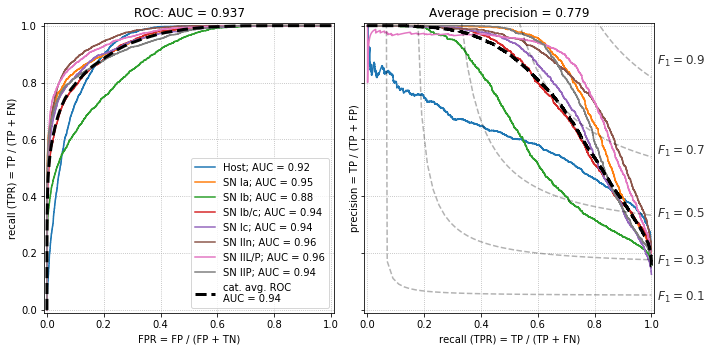

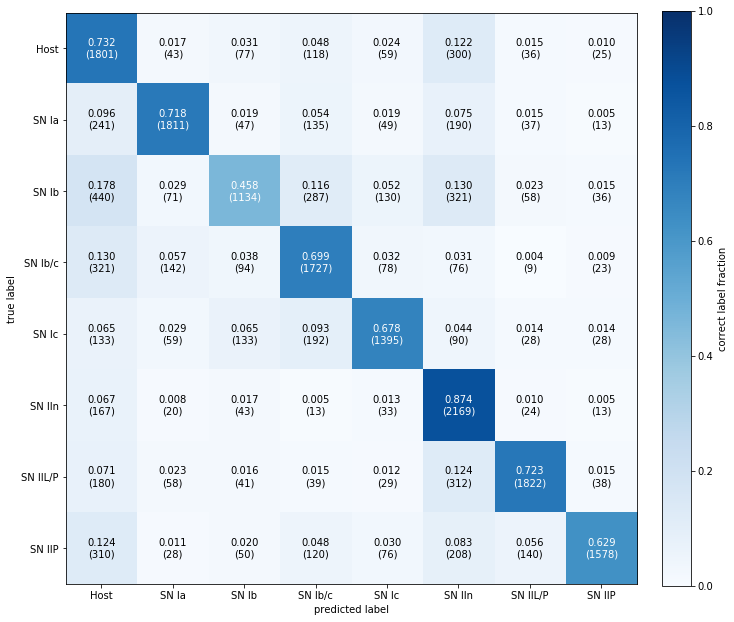

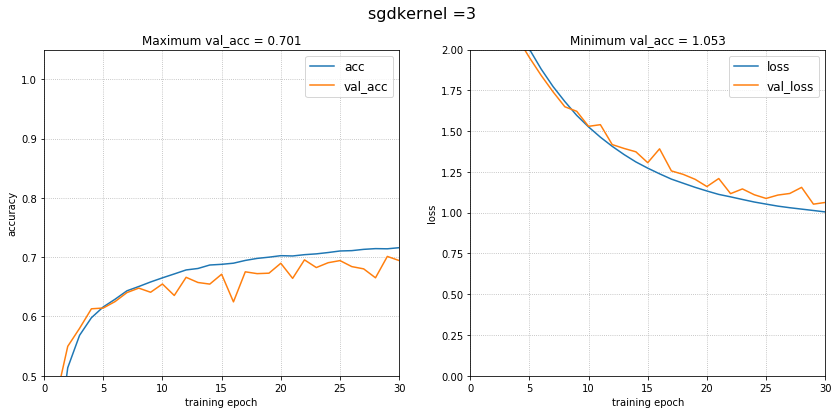

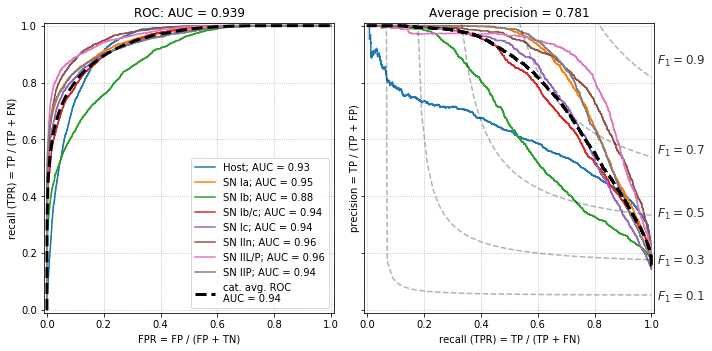

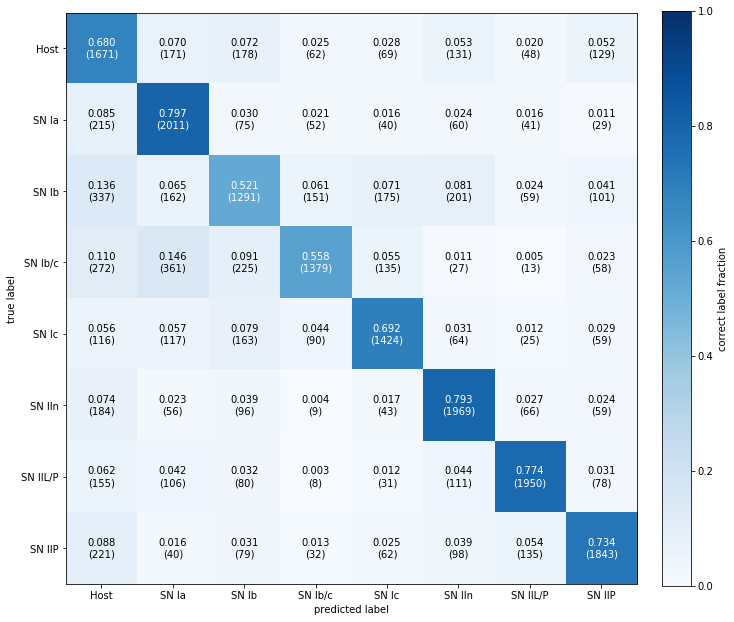

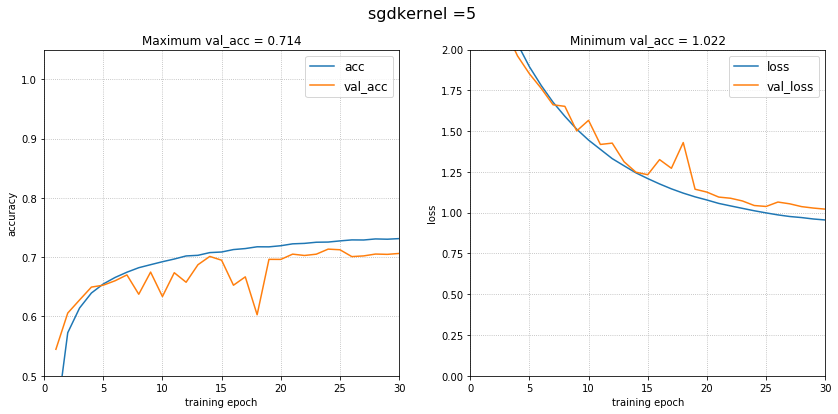

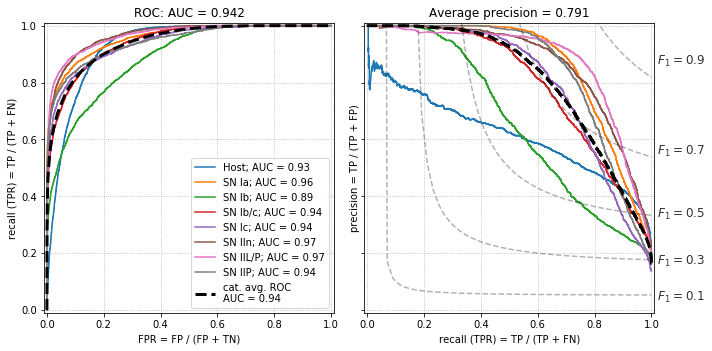

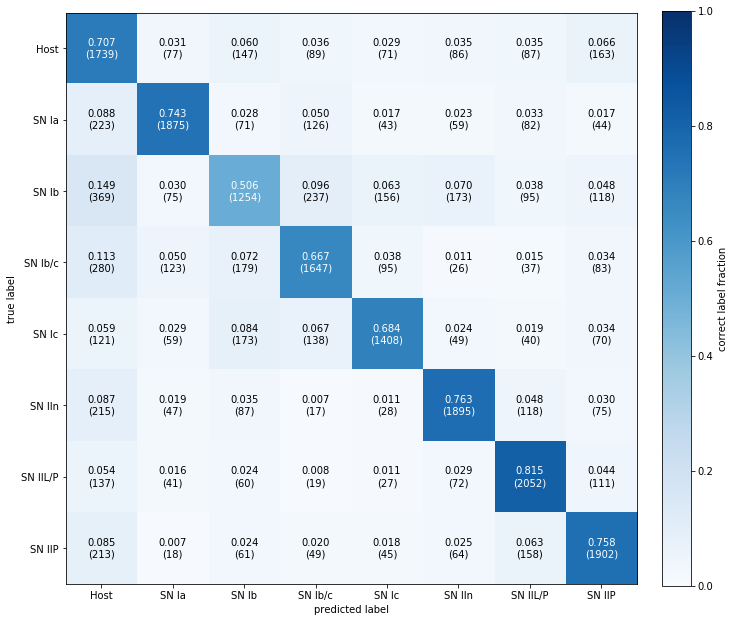

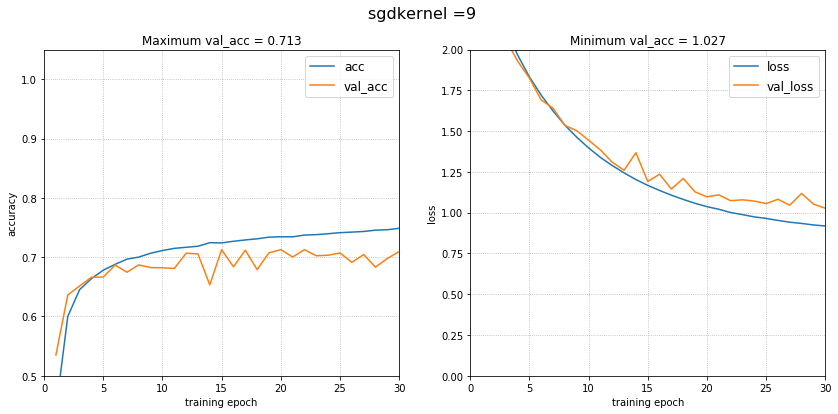

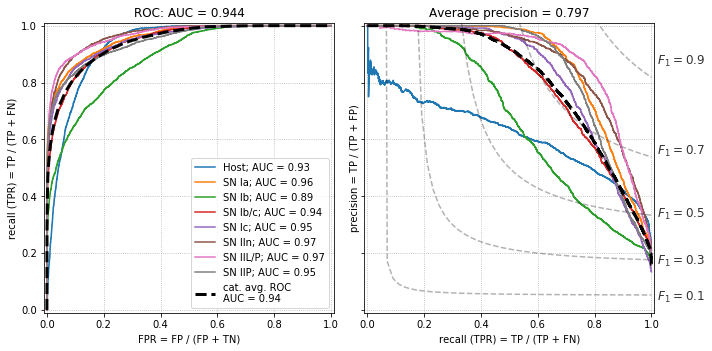

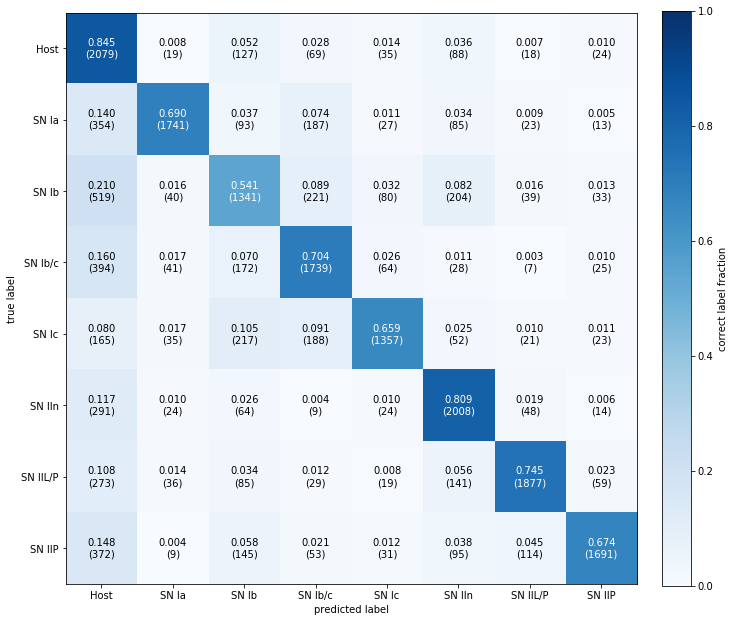

In [61]:
for i in opt_list:
    for j in kernel: 
        optimizer(i,j)

### - The formatting was not working, so doing it for the last three. 
### - Adam(lr=.00021544346900318823) done seperately

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 13s 214us/sample - loss: 3.0338 - acc: 0.3189 - val_loss: 2.8022 - val_acc: 0.3911
Epoch 2/30
58492/58492 [==============================] - 9s 158us/sample - loss: 2.7202 - acc: 0.4006 - val_loss: 2.6234 - val_acc: 0.4293
Epoch 3/30
58492/58492 [==============================] - 9s 158us/sample - loss: 2.5721 - acc: 0.4380 - val_loss: 2.5067 - val_acc: 0.4603
Epoch 4/30
58492/58492 [==============================] - 9s 158us/sample - loss: 2.4694 - acc: 0.4644 - val_loss: 2.4236 - val_acc: 0.4792
Epoch 5/30
58492/58492 [==============================] - 9s 158us/sample - loss: 2.3908 - acc: 0.4806 - val_loss: 2.3578 - val_acc: 0.4931
Epoch 6/30
58492/58492 [==============================] - 9s 158us/sample - loss: 2.3317 - acc: 0.4971 - val_loss: 2.3037 - val_acc: 0.5039
Epoch 7/30
58492/58492 [==============================] - 9s 158us/sample - loss: 2.2803 - acc: 0.5083 - val_

58492/58492 [==============================] - 9s 153us/sample - loss: 3.2137 - acc: 0.2831 - val_loss: 3.1811 - val_acc: 0.3019
Epoch 26/30
58492/58492 [==============================] - 9s 153us/sample - loss: 3.2013 - acc: 0.2881 - val_loss: 3.1715 - val_acc: 0.3055
Epoch 27/30
58492/58492 [==============================] - 9s 154us/sample - loss: 3.1925 - acc: 0.2885 - val_loss: 3.1614 - val_acc: 0.3089
Epoch 28/30
58492/58492 [==============================] - 9s 153us/sample - loss: 3.1834 - acc: 0.2911 - val_loss: 3.1521 - val_acc: 0.3102
Epoch 29/30
58492/58492 [==============================] - 9s 153us/sample - loss: 3.1700 - acc: 0.2991 - val_loss: 3.1428 - val_acc: 0.3130
Epoch 30/30
58492/58492 [==============================] - 9s 153us/sample - loss: 3.1621 - acc: 0.2981 - val_loss: 3.1333 - val_acc: 0.3167
Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 13s 220us/sample - loss: 3.7437 - acc: 0.1269 - val_loss: 

/software/tensorflow/2.0.0b/lib/python3.7/site-packages/ipykernel/__main__.py:205: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 14s 244us/sample - loss: 1.7898 - acc: 0.5308 - val_loss: 1.4741 - val_acc: 0.5803
Epoch 2/30
58492/58492 [==============================] - 10s 176us/sample - loss: 1.2584 - acc: 0.6404 - val_loss: 1.2172 - val_acc: 0.6453
Epoch 3/30
58492/58492 [==============================] - 10s 176us/sample - loss: 1.1654 - acc: 0.6615 - val_loss: 1.2562 - val_acc: 0.6217
Epoch 4/30
58492/58492 [==============================] - 10s 178us/sample - loss: 1.1246 - acc: 0.6723 - val_loss: 1.2611 - val_acc: 0.6250
Epoch 5/30
58492/58492 [==============================] - 10s 176us/sample - loss: 1.1018 - acc: 0.6780 - val_loss: 1.1299 - val_acc: 0.6618
Epoch 6/30
58492/58492 [==============================] - 10s 176us/sample - loss: 1.0844 - acc: 0.6832 - val_loss: 1.1086 - val_acc: 0.6719
Epoch 7/30
58492/58492 [==============================] - 10s 176us/sample - loss: 1.0743 - acc: 0.6862 

/software/tensorflow/2.0.0b/lib/python3.7/site-packages/ipykernel/__main__.py:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/software/tensorflow/2.0.0b/lib/python3.7/site-packages/ipykernel/__main__.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/software/tensorflow/2.0.0b/lib/python3.7/site-packages/ipykernel/__main__.py:205: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control th

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 15s 250us/sample - loss: 1.7129 - acc: 0.5413 - val_loss: 1.2504 - val_acc: 0.6527
Epoch 2/30
58492/58492 [==============================] - 10s 179us/sample - loss: 1.2030 - acc: 0.6571 - val_loss: 1.1461 - val_acc: 0.6723
Epoch 3/30
58492/58492 [==============================] - 10s 179us/sample - loss: 1.1234 - acc: 0.6734 - val_loss: 1.2803 - val_acc: 0.6086
Epoch 4/30
58492/58492 [==============================] - 11s 181us/sample - loss: 1.0908 - acc: 0.6842 - val_loss: 1.1363 - val_acc: 0.6559
Epoch 5/30
58492/58492 [==============================] - 10s 179us/sample - loss: 1.0701 - acc: 0.6907 - val_loss: 1.0638 - val_acc: 0.6884
Epoch 6/30
58492/58492 [==============================] - 10s 179us/sample - loss: 1.0542 - acc: 0.6953 - val_loss: 1.0744 - val_acc: 0.6906
Epoch 7/30
58492/58492 [==============================] - 10s 179us/sample - loss: 1.0441 - acc: 0.6984 

/software/tensorflow/2.0.0b/lib/python3.7/site-packages/ipykernel/__main__.py:104: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/software/tensorflow/2.0.0b/lib/python3.7/site-packages/ipykernel/__main__.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/software/tensorflow/2.0.0b/lib/python3.7/site-packages/ipykernel/__main__.py:205: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control th

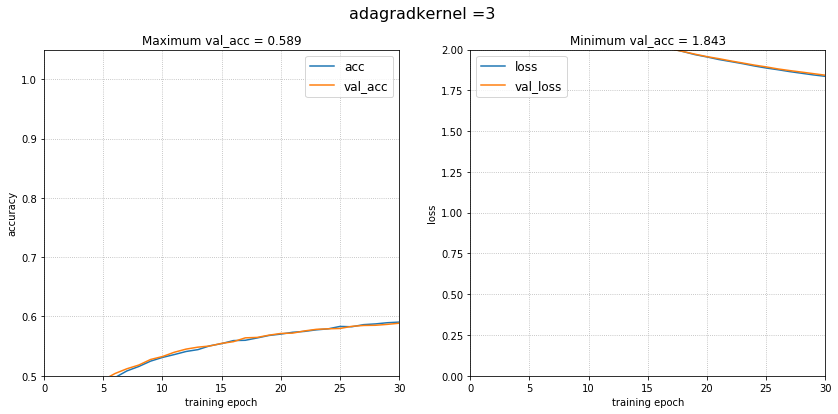

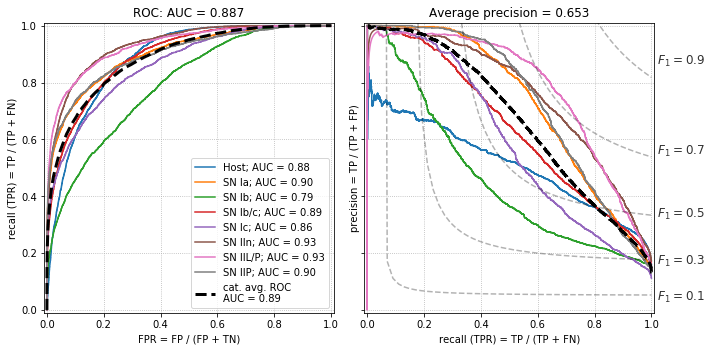

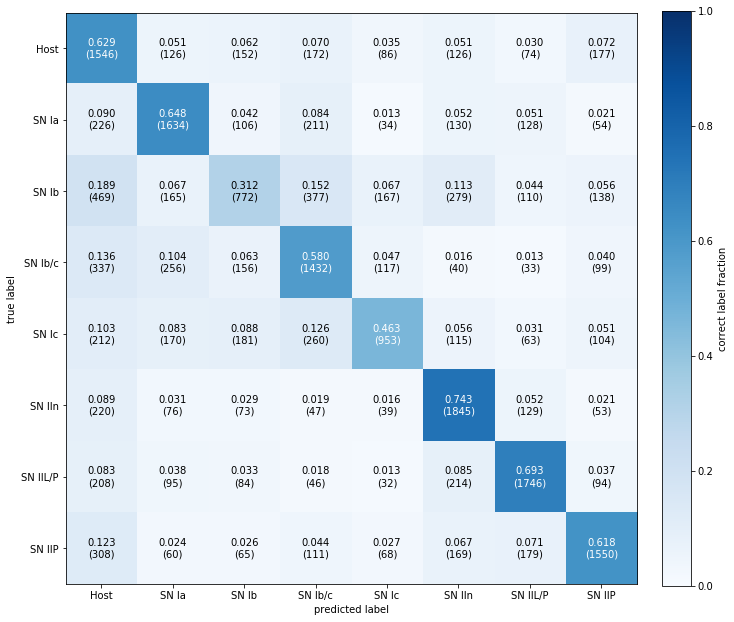

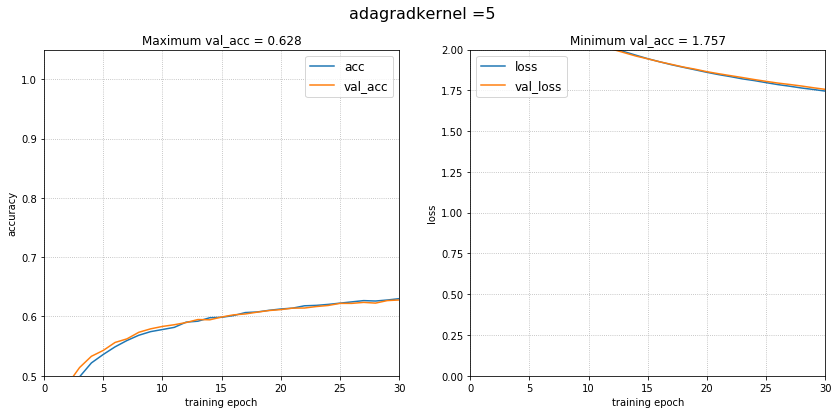

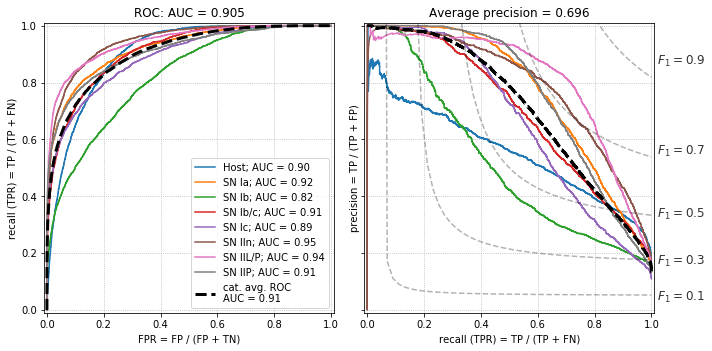

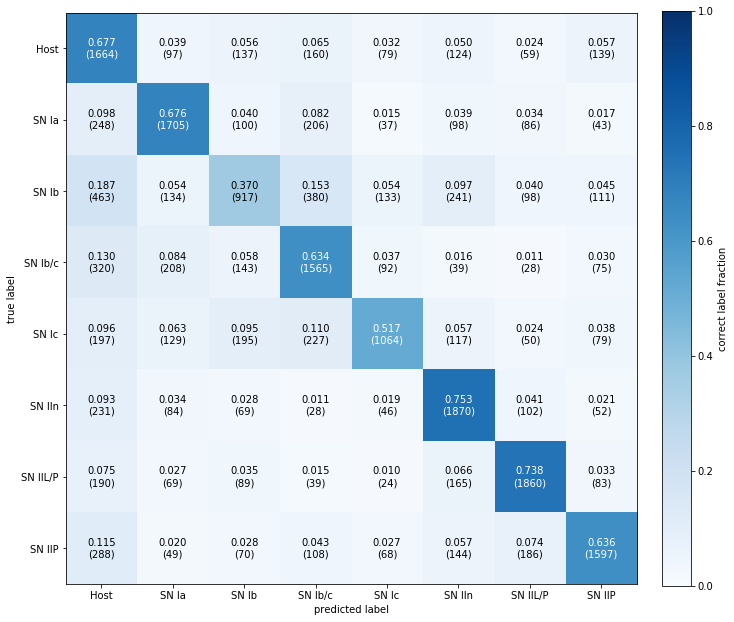

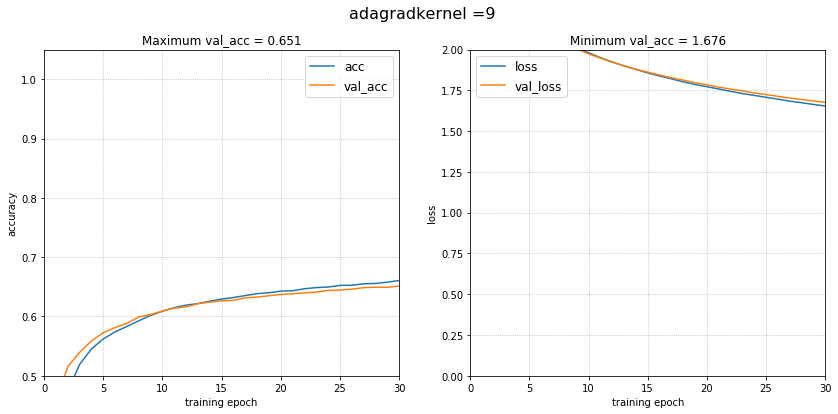

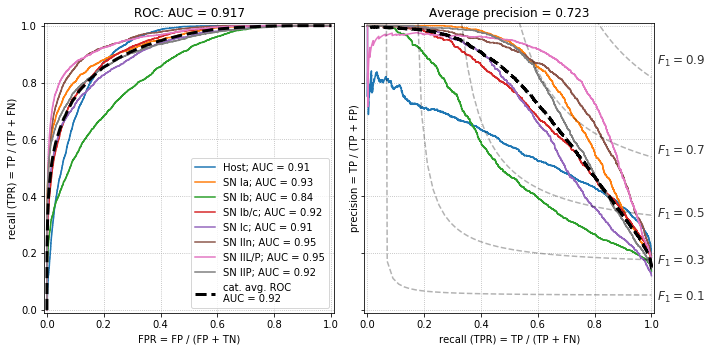

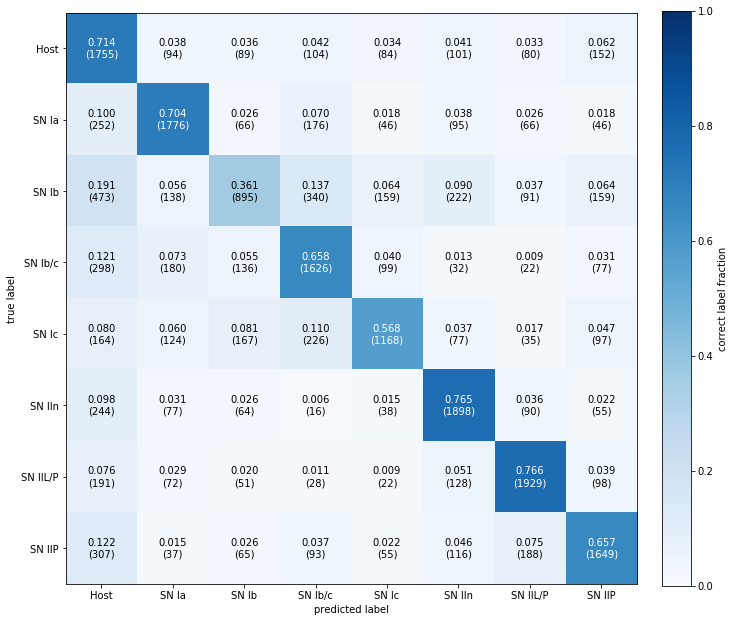

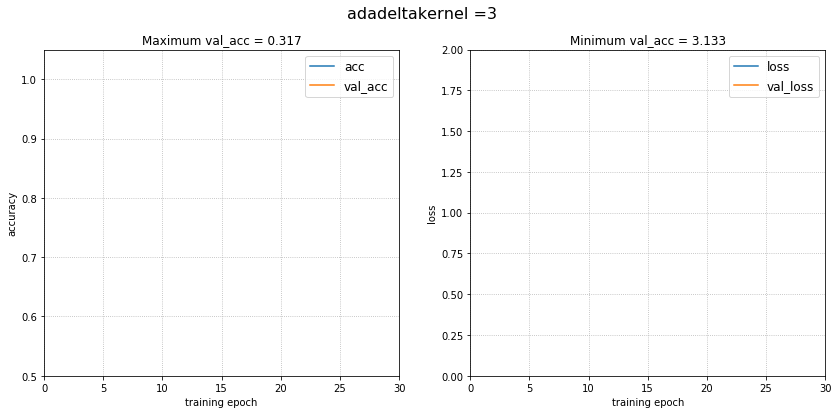

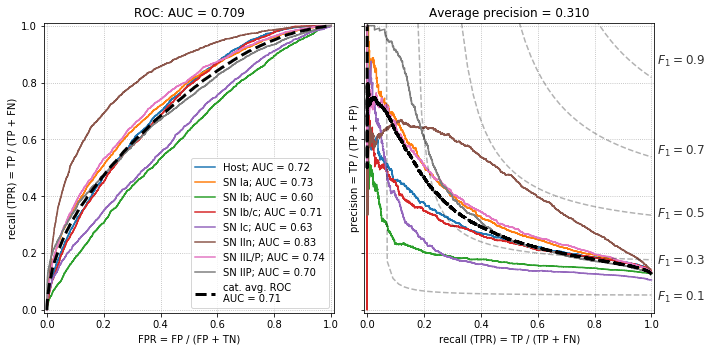

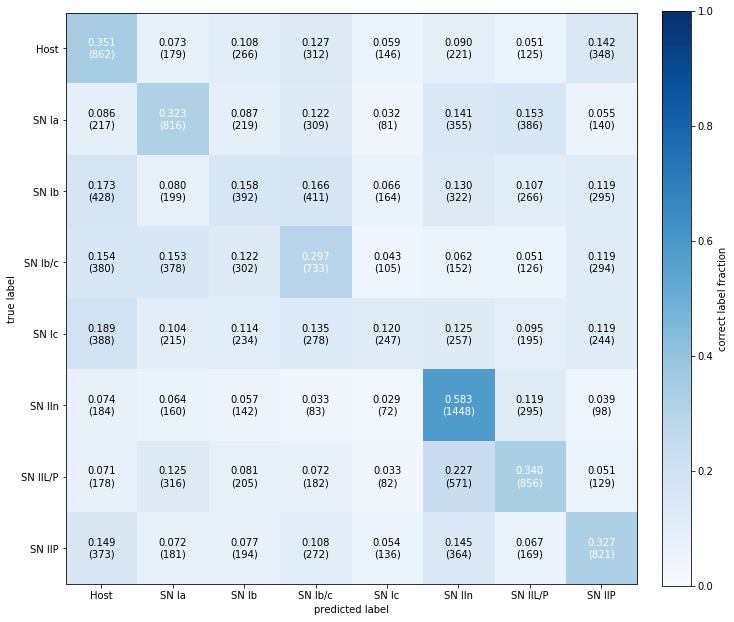

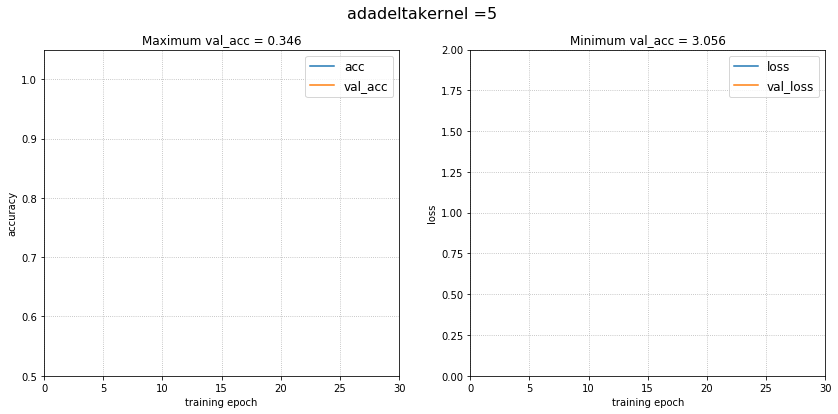

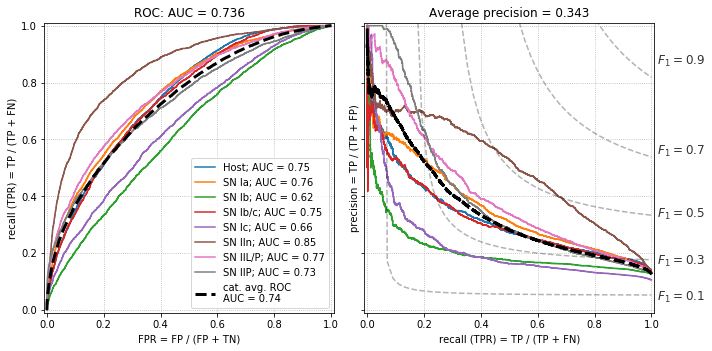

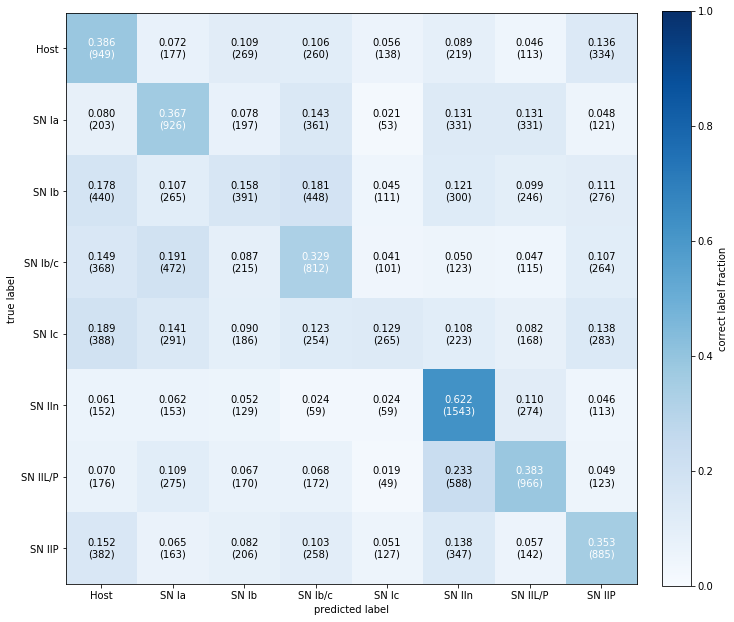

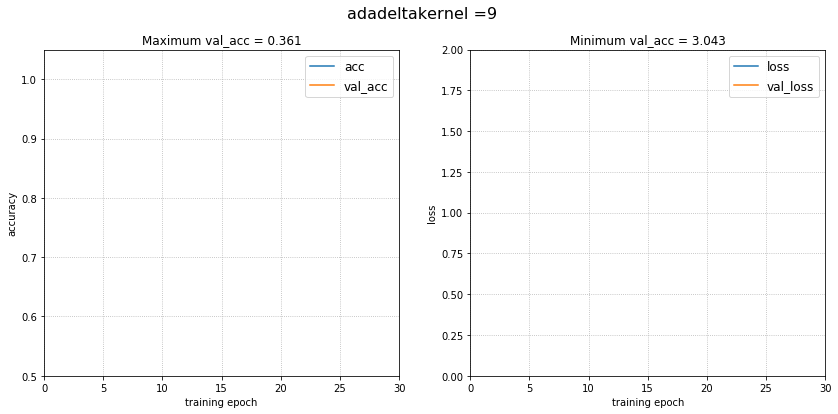

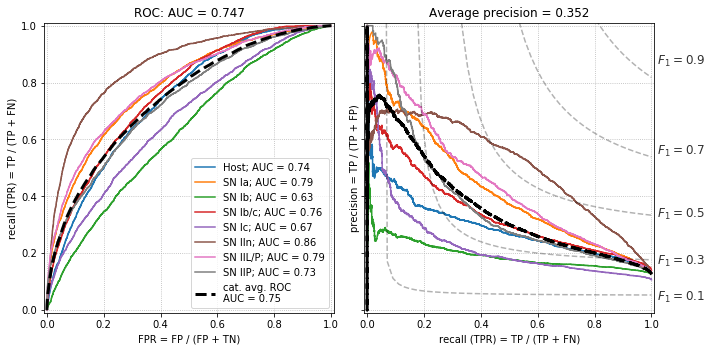

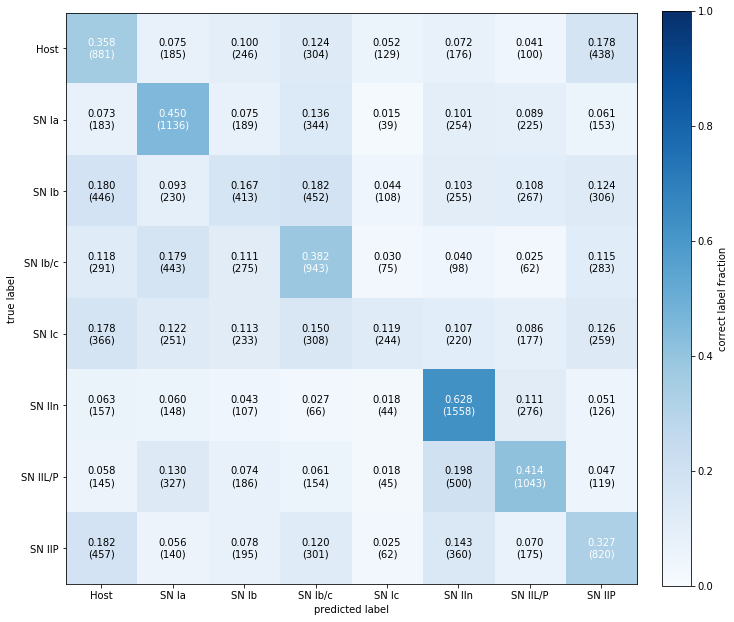

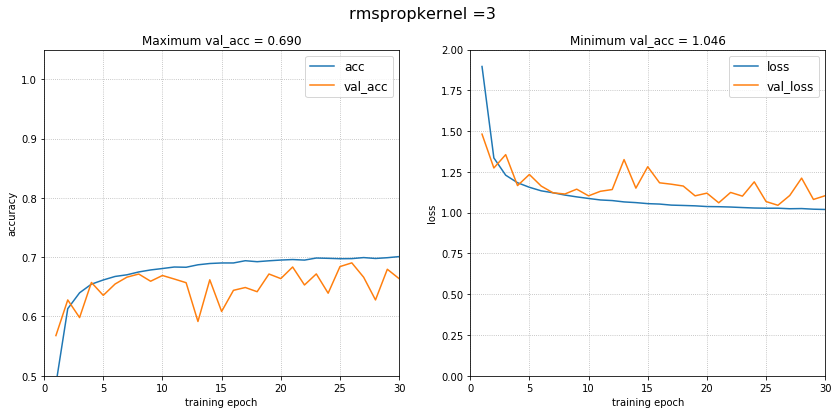

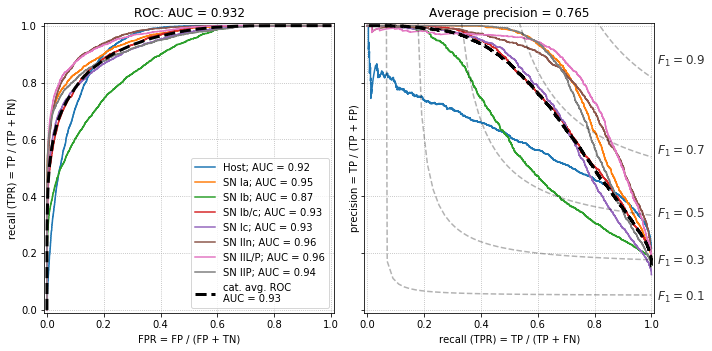

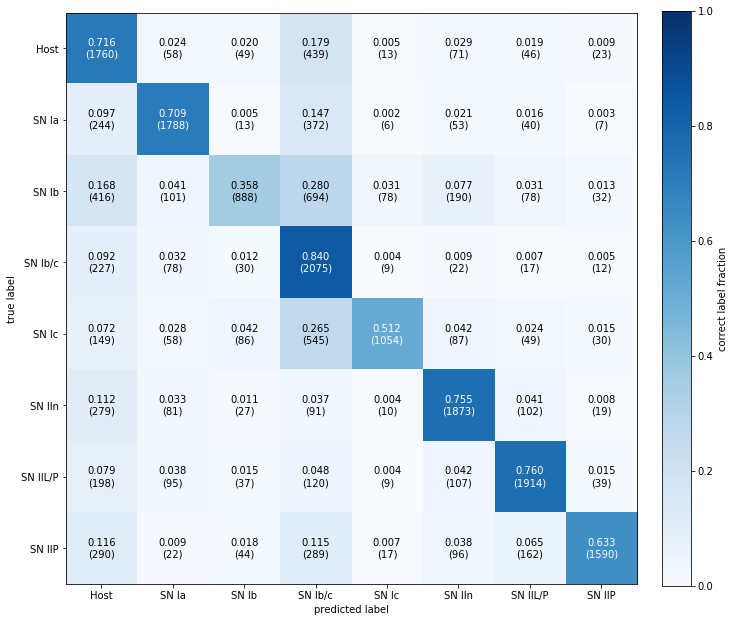

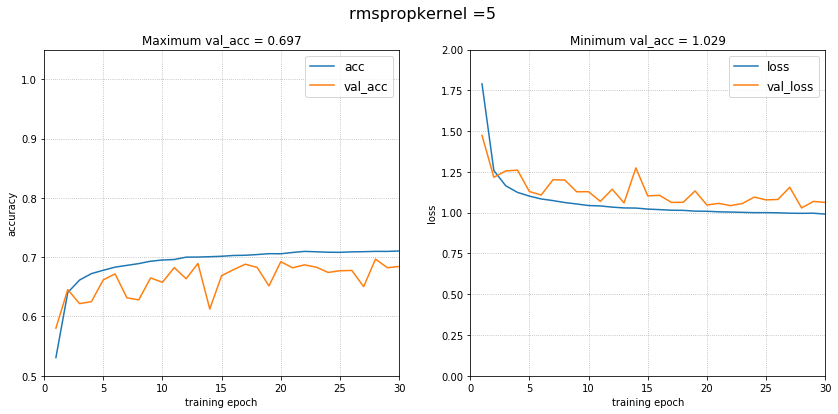

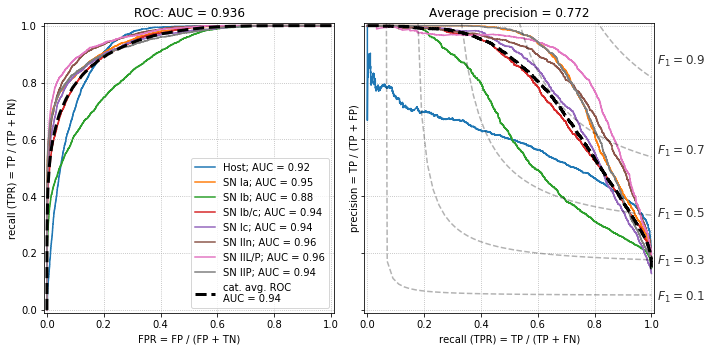

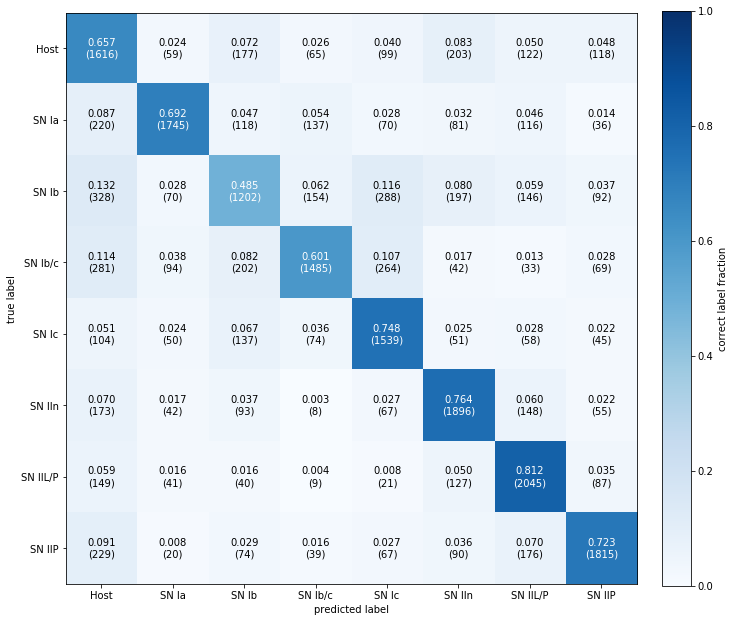

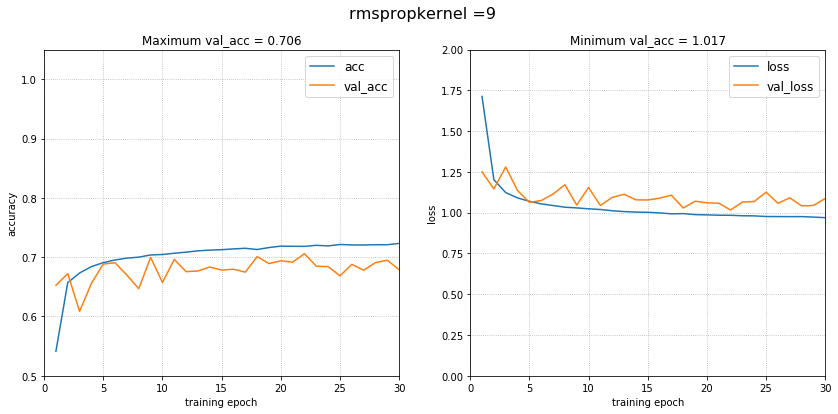

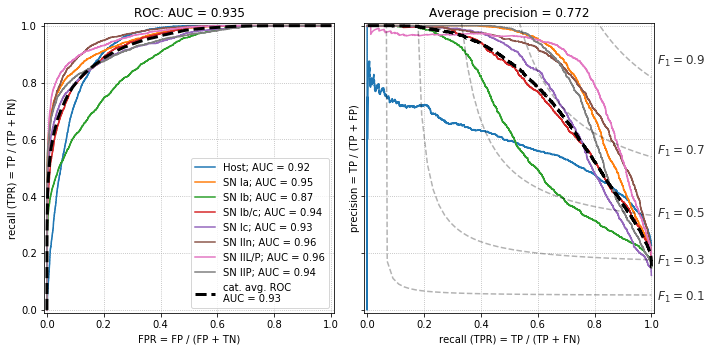

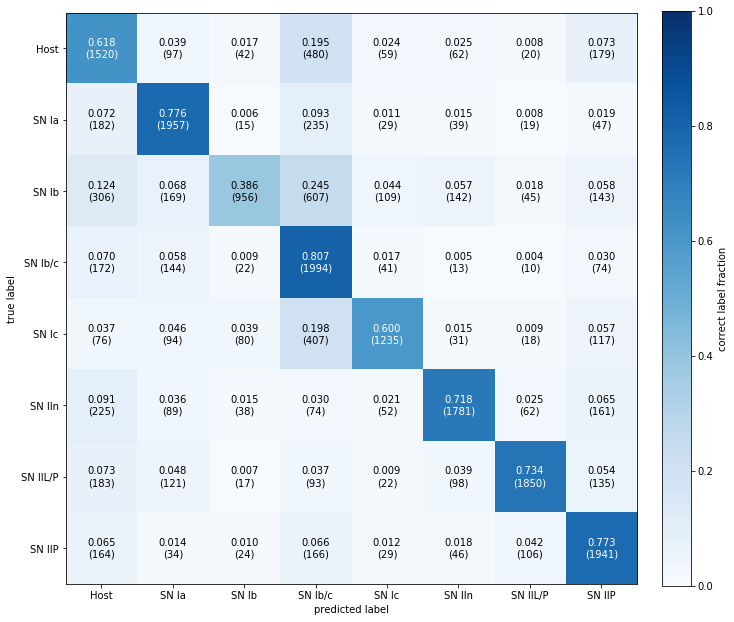

In [62]:
opt_list = ['adagrad','adadelta','rmsprop']
kernel = [3,5,9]
for i in opt_list:
    for j in kernel: 
        optimizer(i,j)

In [63]:
"""Function takes in the optimizer and kernel sizes
returns acc vs epoch plot, the roc, pr curve, and cm"""

def optimizer(optimizer,kernel_size):
    n = kernel_size
    def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
        """Define the CNN structure.

        Parameters
        ----------
        input_shape : int
        Shape of the input spectra.
        ncat : int
        Number of categories.
        learning_rate : float
        Learning rate.
        reg : float
        Regularization factor.
        dropout : float
        Dropout rate.
        seed : int
        Seed of initializer.

        Returns
        -------
        model : tensorflow.keras.Model
        A model instance of the network.
        """

        X_input = Input(input_shape, name='Input_Spec')

        # First convolutional layer.
        with backend.name_scope('Conv_1'):
            X = Conv1D(filters=8, kernel_size=n, strides=1, padding='same',
                       kernel_regularizer=regularizers.l2(reg),
                       bias_initializer='zeros',
                       kernel_initializer=glorot_normal(seed))(X_input)
            X = BatchNormalization(axis=2)(X)
            X = Activation('relu')(X)
            X = MaxPooling1D(pool_size= 2)(X)

        # Second convolutional layer.
        with backend.name_scope('Conv_2'):
            X = Conv1D(filters=16, kernel_size=n, strides=1, padding='same',
                       kernel_regularizer=regularizers.l2(reg),
                       bias_initializer='zeros',
                       kernel_initializer=glorot_normal(seed))(X)
            X = BatchNormalization(axis=2)(X)
            X = Activation('relu')(X)
            X = MaxPooling1D(2)(X)

        # Third convolutional layer.
        with backend.name_scope('Conv_3'):
            X = Conv1D(filters=32, kernel_size=n, strides=1, padding='same',
                       kernel_regularizer=regularizers.l2(reg),
                       bias_initializer='zeros',
                       kernel_initializer=glorot_normal(seed))(X)
            X = BatchNormalization(axis=2)(X)
            X = Activation('relu')(X)
            X = MaxPooling1D(2)(X)

        # Fourth convolutional layer.
        with backend.name_scope('Conv_4'):
            X = Conv1D(filters=64, kernel_size=n, strides=1, padding='same',
                       kernel_regularizer=regularizers.l2(reg),
                       bias_initializer='zeros',
                       kernel_initializer=glorot_normal(seed))(X)
            X = BatchNormalization(axis=2)(X)
            X = Activation('relu')(X)
            X = MaxPooling1D(2)(X)

        # Flatten to fully connected dense layer.
        with backend.name_scope('Dense_Layer'):
            X = Flatten()(X)
            X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                      activation='relu')(X)
            X = Dropout(rate=dropout, seed=seed)(X)

        #     with backend.name_scope('Dense_Layer'):
        #         X = Flatten()(X)
        #         X = Dense(512, kernel_regularizer=regularizers.l2(reg),
        #                   activation='relu')(X)
        #         X = Dropout(rate=dropout, seed=seed)(X)

        # Output layer with sigmoid activation.
        with backend.name_scope('Output_Layer'):
            X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
                  activation='softmax',name='Output_Classes')(X)

        model = Model(inputs=X_input, outputs=X, name='SNnet')

        # Set up optimizer, loss function, and optimization metrics.
        model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                      metrics=['accuracy'])

        return model
    
    # Training and testing the model
    model = network((nbins, 1),ncat=y.shape[1])
    hist = model.fit(x_train, y_train, batch_size=65, epochs=30, validation_data=(x_test, y_test), shuffle=True)
    
    title = "Adam(lr=.000215...) kernel ={0}".format(n)
    # Plotting epoch vs accuracy 
    fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=True)
    fig.suptitle(title, fontsize=16)
    nepoch = len(hist.history['loss'])
    epochs = np.arange(1, nepoch+1)

    ax = axes[0]
    ax.plot(epochs, hist.history['acc'], label='acc')
    ax.plot(epochs, hist.history['val_acc'], label='val_acc')
    ax.set(xlabel='training epoch',
           ylabel='accuracy',
           xlim=(0, nepoch),
           ylim=(0.5,1.05))
    ax.set_title('Maximum val_acc = {0:2.3f}'.format(max(hist.history['val_acc'])))
    ax.legend(fontsize=12, loc='best')
    ax.grid(ls=':')

    ax = axes[1]
    ax.plot(epochs, hist.history['loss'], label='loss')
    ax.plot(epochs, hist.history['val_loss'], label='val_loss')
    ax.set(xlabel='training epoch',
           ylabel='loss',
           xlim=(0, nepoch),
           ylim=(0.,2.0))
    ax.set_title('Minimum val_acc = {0:2.3f}'.format(min(hist.history['val_loss'])))
    ax.legend(fontsize=12, loc='best')
    ax.grid(ls=':')
    
    # Print ROC and PR Curve
    y_pred = model.predict(x_test)

    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

    fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

    all_fpr = None
    all_tpr = None

    fpr = dict()
    tpr = dict()
    pre = dict()
    rec = dict()
    for i in range(ntypes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
        roc_auc = auc(fpr[i], tpr[i])

        ax = axes[0]
        ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
        ax.grid(ls=':')

        pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        ax = axes[1]
        ax.plot(rec[i], pre[i])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(ntypes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr / ntypes
    fpr['macro'] = np.insert(fpr['macro'], 0, 0)
    tpr['macro'] = np.insert(tpr['macro'], 0, 0)
    roc_auc_macro = auc(fpr['macro'], tpr['macro'])

    ax = axes[0]
    ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
            label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
    ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
           ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
           title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
           aspect='equal')
    ax.legend(fontsize=10, loc='lower right')

    ax = axes[1]
    pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
    ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

    f_scores = np.linspace(0.1, 0.9, num=5)
    for f_score in f_scores:
        x_ = np.linspace(0.01, 1)
        y_ = f_score * x_ / (2 * x_ - f_score)
        l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
        ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                    fontsize=12, alpha=0.8)
    ax.grid(ls=':')
    ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
           ylabel='precision = TP / (TP + FP)',
           title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
           aspect='equal')

    fig.tight_layout()
    
    
    # CM
    from sklearn.metrics import confusion_matrix

    # In the multilabel classifier, test that the maximum of the
    # output matrix of values matches.
    cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(1,1, figsize=(10,9))

    im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
    cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cb.set_label('correct label fraction')

    ax.set(aspect='equal',
           xlabel='predicted label',
           xticks=np.arange(cm.shape[1]),
           xticklabels=labels,
           ylabel='true label',
           yticks=np.arange(cm.shape[1]),
           yticklabels=labels)

    thresh = 0.5*cm.max()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                    ha='center', va='center',
                    color='black' if cm[i,j] < thresh else 'white')
    plt.ylim([7.5,-.5])
    fig.tight_layout()

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 14s 238us/sample - loss: 2.7083 - acc: 0.3818 - val_loss: 2.1823 - val_acc: 0.5094
Epoch 2/30
58492/58492 [==============================] - 10s 164us/sample - loss: 1.9565 - acc: 0.5456 - val_loss: 1.7673 - val_acc: 0.5776
Epoch 3/30
58492/58492 [==============================] - 10s 164us/sample - loss: 1.6594 - acc: 0.5943 - val_loss: 1.5724 - val_acc: 0.5997
Epoch 4/30
58492/58492 [==============================] - 10s 164us/sample - loss: 1.4881 - acc: 0.6209 - val_loss: 1.4304 - val_acc: 0.6303
Epoch 5/30
58492/58492 [==============================] - 10s 164us/sample - loss: 1.3752 - acc: 0.6369 - val_loss: 1.3602 - val_acc: 0.6350
Epoch 6/30
58492/58492 [==============================] - 10s 164us/sample - loss: 1.2979 - acc: 0.6528 - val_loss: 1.2857 - val_acc: 0.6496
Epoch 7/30
58492/58492 [==============================] - 10s 164us/sample - loss: 1.2423 - acc: 0.6630 

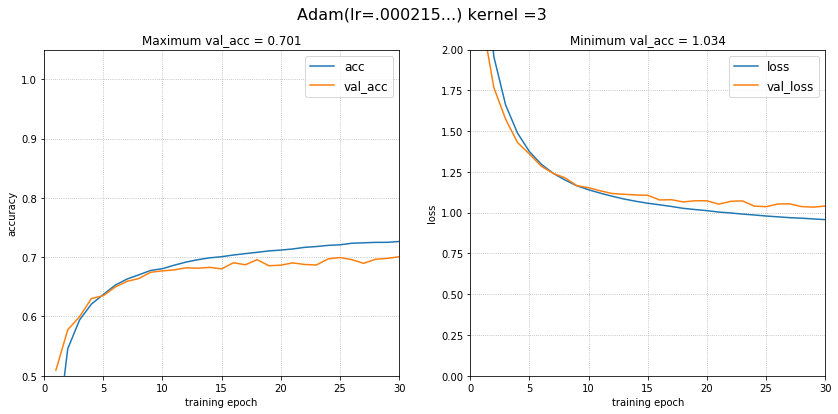

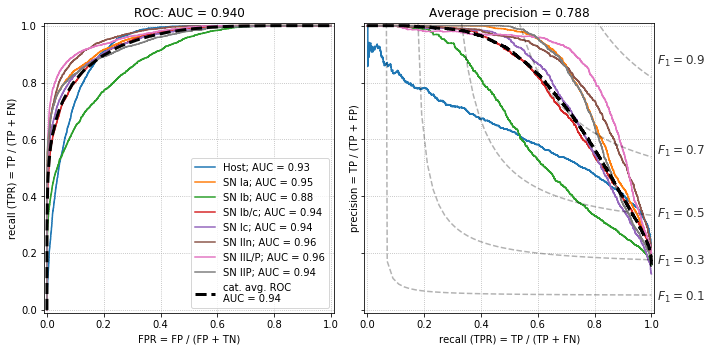

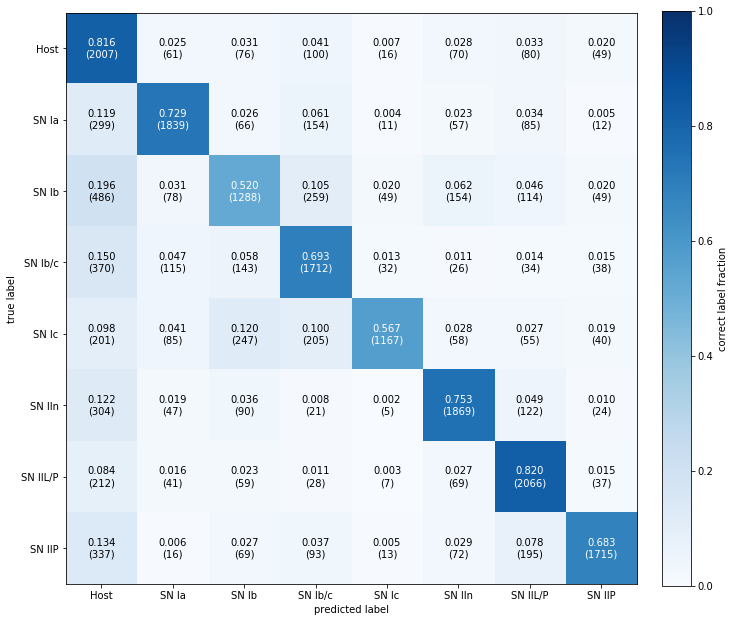

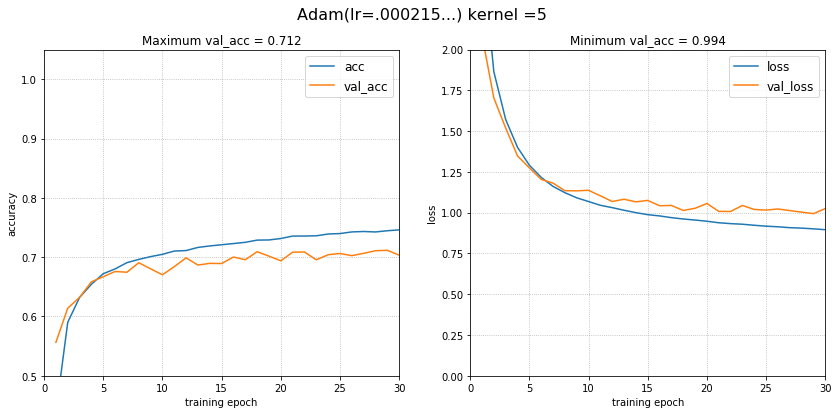

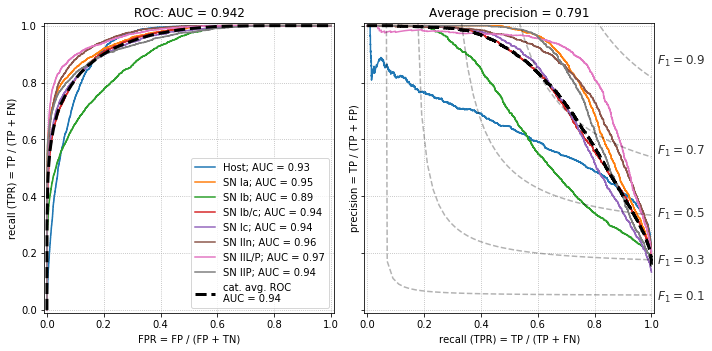

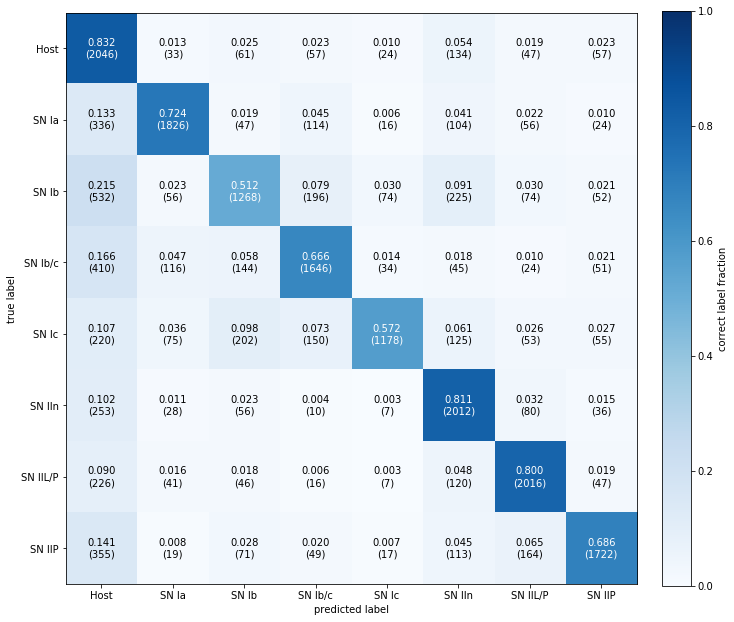

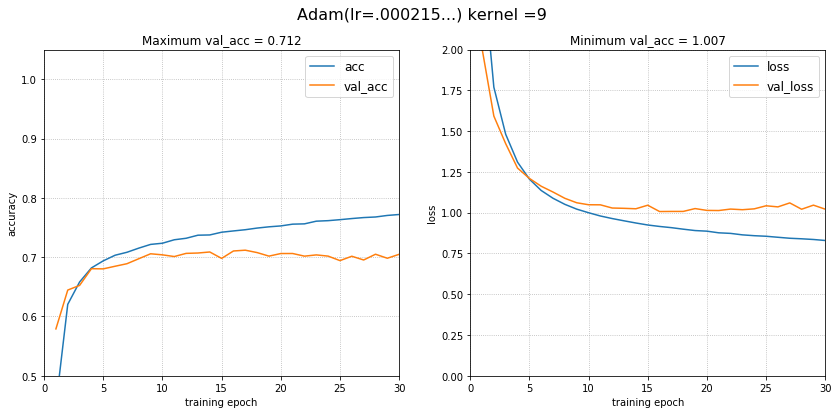

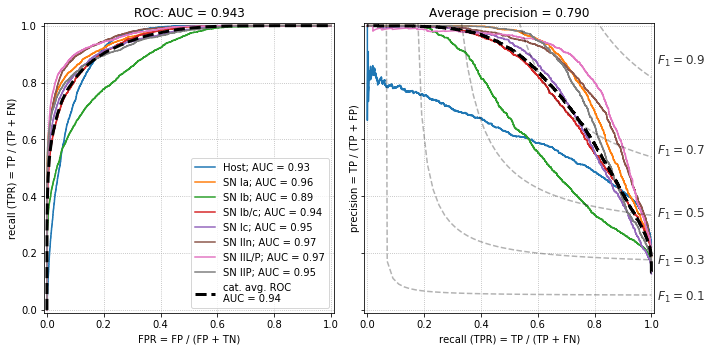

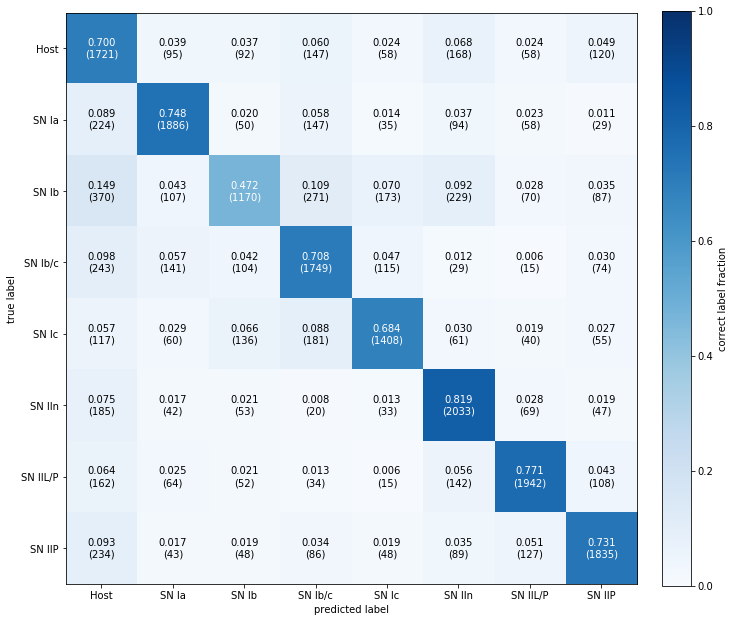

In [64]:
for j in kernel: 
        optimizer(Adam(lr=.00021544346900318823),j)

# LTSM Layer

In [65]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
#         X = BatchNormalization(axis=2)(X)
#         X = Activation('relu')(X)
#         X = MaxPooling1D(pool_size= 2)(X)
    
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)
        
    with backend.name_scope('LSTM_1'):
#         X = LSTM(units = 50, return_sequences = True)
        X = LSTM(32, return_sequences=True)(X)

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
        
#     with backend.name_scope('Dense_Layer'):
#         X = Flatten()(X)
#         X = Dense(512, kernel_regularizer=regularizers.l2(reg),
#                   activation='relu')(X)
#         X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
   
    model.compile(optimizer=Adam(lr=learning_rate),
           loss='categorical_crossentropy',
                  metrics=['accuracy'])
    # Set up optimizer, loss function, and optimization metrics.
#     model.compile(optimizer=tensorflow.keras.optimizers.Adadelta(),
#            loss='categorical_crossentropy',
#                   metrics=['accuracy'])
    
    return model

In [67]:
model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test), shuffle=True)

fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=True)
fig.suptitle('lstm in the middle after conv1d_1', fontsize=16)
nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['acc'], label='acc')
ax.plot(epochs, hist.history['val_acc'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.5,1.05))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       ylim=(0.,2.0))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')
# Print ROC and PR Curve
y_pred = model.predict(x_test)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])

    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')

    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])

ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()


# CM
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 195s 3ms/sample - loss: 2.5411 - acc: 0.4638 - val_loss: 2.0414 - val_acc: 0.5691
Epoch 2/30
58492/58492 [==============================] - 189s 3ms/sample - loss: 1.7972 - acc: 0.6198 - val_loss: 1.6316 - val_acc: 0.6402
Epoch 3/30
58492/58492 [==============================] - 189s 3ms/sample - loss: 1.5188 - acc: 0.6551 - val_loss: 1.4360 - val_acc: 0.6642
Epoch 4/30
35136/58492 [=================>............] - ETA: 1:09 - loss: 1.3794 - acc: 0.6727

KeyboardInterrupt: 

In [68]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
#         X = BatchNormalization(axis=2)(X)
#         X = Activation('relu')(X)
#         X = MaxPooling1D(pool_size= 2)(X)
    
    with backend.name_scope('LSTM_1'):
#         X = LSTM(units = 50, return_sequences = True)
        X = LSTM(32, return_sequences=True,input_shape=(nbins,1))

    
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)
        

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
        
#     with backend.name_scope('Dense_Layer'):
#         X = Flatten()(X)
#         X = Dense(512, kernel_regularizer=regularizers.l2(reg),
#                   activation='relu')(X)
#         X = Dropout(rate=dropout, seed=seed)(X)
    
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
   
    model.compile(optimizer=Adam(lr=learning_rate),
           loss='categorical_crossentropy',
                  metrics=['accuracy'])
    # Set up optimizer, loss function, and optimization metrics.
#     model.compile(optimizer=tensorflow.keras.optimizers.Adadelta(),
#            loss='categorical_crossentropy',
#                   metrics=['accuracy'])
    
    return model

Train on 58492 samples, validate on 19498 samples
Epoch 1/30
58492/58492 [==============================] - 15s 258us/sample - loss: 2.5854 - acc: 0.4400 - val_loss: 2.0640 - val_acc: 0.5612
Epoch 2/30
58492/58492 [==============================] - 10s 174us/sample - loss: 1.8582 - acc: 0.5877 - val_loss: 1.7018 - val_acc: 0.6133
Epoch 3/30
58492/58492 [==============================] - 10s 174us/sample - loss: 1.5665 - acc: 0.6308 - val_loss: 1.4752 - val_acc: 0.6427
Epoch 4/30
58492/58492 [==============================] - 10s 175us/sample - loss: 1.3971 - acc: 0.6549 - val_loss: 1.3733 - val_acc: 0.6479
Epoch 5/30
58492/58492 [==============================] - 10s 175us/sample - loss: 1.2894 - acc: 0.6704 - val_loss: 1.2780 - val_acc: 0.6645
Epoch 6/30
58492/58492 [==============================] - 10s 179us/sample - loss: 1.2148 - acc: 0.6802 - val_loss: 1.2115 - val_acc: 0.6748
Epoch 7/30
58492/58492 [==============================] - 10s 175us/sample - loss: 1.1630 - acc: 0.6892 

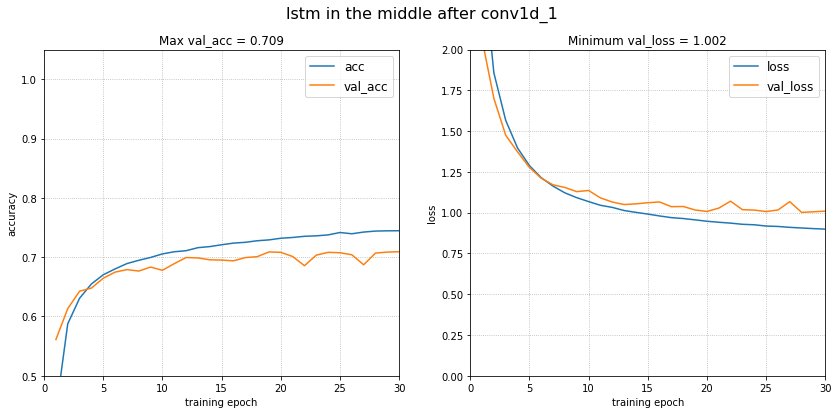

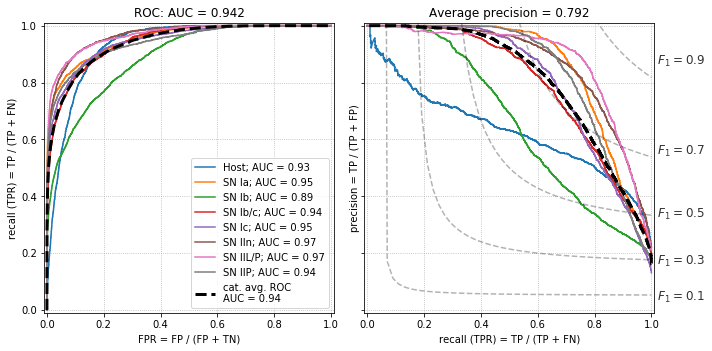

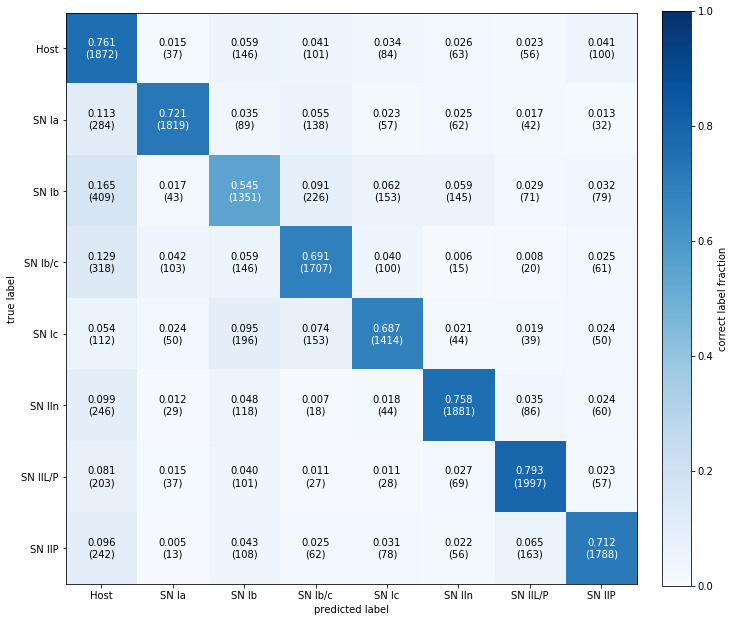

In [70]:
model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test), shuffle=True)

fig, axes = plt.subplots(1,2, figsize=(14,6), sharex=True)
fig.suptitle('lstm in the middle after conv1d_1', fontsize=16)
nepoch = len(hist.history['loss'])
epochs = np.arange(1, nepoch+1)

ax = axes[0]
ax.plot(epochs, hist.history['acc'], label='acc')
ax.plot(epochs, hist.history['val_acc'], label='val_acc')
ax.set(xlabel='training epoch',
       ylabel='accuracy',
       xlim=(0, nepoch),
       ylim=(0.5,1.05))
ax.set_title('Max val_acc = {0:2.3f}'.format(max(hist.history['val_acc'])))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')

ax = axes[1]
ax.plot(epochs, hist.history['loss'], label='loss')
ax.plot(epochs, hist.history['val_loss'], label='val_loss')
ax.set(xlabel='training epoch',
       ylabel='loss',
       xlim=(0, nepoch),
       ylim=(0.,2.0))
ax.set_title('Minimum val_loss = {0:2.3f}'.format(min(hist.history['val_loss'])))
ax.legend(fontsize=12, loc='best')
ax.grid(ls=':')
# Print ROC and PR Curve
y_pred = model.predict(x_test)

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

all_fpr = None
all_tpr = None

fpr = dict()
tpr = dict()
pre = dict()
rec = dict()
for i in range(ntypes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])        
    roc_auc = auc(fpr[i], tpr[i])

    ax = axes[0]
    ax.plot(fpr[i], tpr[i], label='{}; AUC = {:.2f}'.format(labels[i], roc_auc))
    ax.grid(ls=':')

    pre[i], rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

    ax = axes[1]
    ax.plot(rec[i], pre[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(ntypes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(ntypes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr / ntypes
fpr['macro'] = np.insert(fpr['macro'], 0, 0)
tpr['macro'] = np.insert(tpr['macro'], 0, 0)
roc_auc_macro = auc(fpr['macro'], tpr['macro'])

ax = axes[0]
ax.plot(fpr['macro'], tpr['macro'], lw=3, ls='--', color='k',
        label='cat. avg. ROC\nAUC = {:.2f}'.format(roc_auc_macro))
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(roc_auc_macro),
       aspect='equal')
ax.legend(fontsize=10, loc='lower right')

ax = axes[1]
pre['micro'], rec['micro'], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
ax.plot(rec['micro'], pre['micro'], lw=3, ls='--', color='k')

f_scores = np.linspace(0.1, 0.9, num=5)
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_test, y_pred)),
       aspect='equal')

fig.tight_layout()


# CM
from sklearn.metrics import confusion_matrix

# In the multilabel classifier, test that the maximum of the
# output matrix of values matches.
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(10,9))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label fraction')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=labels,
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=labels)

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([7.5,-.5])
fig.tight_layout()

# END
## Unrelated to this notebook: Trying with the architecture

In [91]:
def network(input_shape, ncat, learning_rate=.00021544346900318823, reg=0.0032, dropout=0.1, seed=1):
    """Define the CNN structure.
    
    Parameters
    ----------
    input_shape : int
        Shape of the input spectra.
    ncat : int
        Number of categories.
    learning_rate : float
        Learning rate.
    reg : float
        Regularization factor.
    dropout : float
        Dropout rate.
    seed : int
        Seed of initializer.
    
    Returns
    -------
    model : tensorflow.keras.Model
        A model instance of the network.
    """
    X_input = Input(input_shape, name='Input_Spec')

    # First convolutional layer.
#         X = BatchNormalization(axis=2)(X)
#         X = Activation('relu')(X)
#         X = MaxPooling1D(pool_size= 2)(X)
    
    with backend.name_scope('LSTM_1'):
#         X = LSTM(units = 50, return_sequences = True)
        X = LSTM(32, return_sequences=True,input_shape=(nbins,1))

    
    with backend.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)
        

    # Second convolutional layer.
    with backend.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
#         X = MaxPooling1D(2)(X)
        
    # Third convolutional layer.
    with backend.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    # Fourth convolutional layer.
    with backend.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
#         X = MaxPooling1D(2)(X)

    # Flatten to fully connected dense layer.
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
#         X = Dropout(rate=dropout, seed=seed)(X)
    
    with backend.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(512, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
        
    # Output layer with sigmoid activation.
    with backend.name_scope('Output_Layer'):
        X = Dense(ncat, kernel_regularizer=regularizers.l2(reg),
              activation='softmax',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
   
    model.compile(optimizer=Adam(lr=learning_rate),
           loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [93]:
model = network((nbins, 1),ncat=y.shape[1])

hist = model.fit(x_train, y_train, batch_size=64, epochs=30, validation_data=(x_test, y_test), shuffle=True)


Train on 58492 samples, validate on 19498 samples
Epoch 1/30


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[64,16,75,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Conv_2_51/max_pooling1d_204/MaxPool-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_106/acc/Identity/_12251]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[64,16,75,1] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node Conv_2_51/max_pooling1d_204/MaxPool-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.